In [1]:
import pandas as pd
import torch
from transformers import DistilBertForSequenceClassification, DistilBertModel, DistilBertTokenizer, DistilBertConfig, EarlyStoppingCallback, TrainingArguments, Trainer
from torch.utils.data import Dataset
from transformers.data.processors.utils import InputFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Data transformation

In [2]:
# Read training, validation, and test data
train = pd.read_csv("processed_train.tsv", sep='\t')
val = pd.read_csv("processed_val.tsv", sep='\t')
test = pd.read_csv("processed_test.tsv", sep='\t')

emotion = pd.unique(train['emotion'])
label_map = { v:i for i, v in enumerate(emotion) }

In [3]:
# Use cuda if it's available
if torch.cuda.is_available():      
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
# Preparing dataset for the distilBert model
class ClassificationDataset(Dataset):
    def __init__(self, text, target, label_map):
        super(ClassificationDataset).__init__()
        self.text = text
        self.target = target
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.max_len = 64
        self.label_map = label_map
      
    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = str(self.text[item])
        text = " ".join(text.split())
        
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )      
        return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [5]:
train_dataset = ClassificationDataset(
    train["text"].to_list(),
    train["emotion"].to_list(),
    label_map
)
val_dataset = ClassificationDataset(
    val["text"].to_list(),
    val["emotion"].to_list(),
    label_map
)
test_dataset = ClassificationDataset(
    test["text"].to_list(),
    test["emotion"].to_list(),
    label_map
)

# Model building

In [6]:
# Modified version of the focal loss provided by pytorch
def softmax_focal_loss_with_regularization(inputs, targets, model, alpha = None, gamma = 2, reduction = "none", reg_type: str = "l2", reg_weight: float = 1e-3):
    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    p = torch.exp(-ce_loss)
    loss = ce_loss * ((1 - p) ** gamma)
    
    # Alpha weighting for different classes
    if alpha is not None:
        batch_size, num_classes = inputs.size()
        class_mask = torch.zeros((batch_size, num_classes), device=inputs.device)
        class_mask.scatter_(1, targets.unsqueeze(1), 1.)
        alpha_t = torch.sum(alpha.to(inputs.device) * class_mask.to(inputs.device), dim=1)
        loss = alpha_t * loss
    
    # L1/L2 regularization
    reg_loss = 0
    for param in model.parameters():
        if reg_type == "l1":
            reg_loss += torch.sum(torch.abs(param))
        else:
            reg_loss += torch.sum(param ** 2)
    loss = loss + reg_weight * reg_loss

    if reduction == "none":
        pass
    elif reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()
    else:
        raise ValueError(f"Invalid Value for arg 'reduction': '{reduction} \\n Supported reduction modes: 'none', 'mean', 'sum'")
    
    return loss

In [7]:
# New model for fine-tuning
class CustomSequenceClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.pre_classifier = nn.Linear(self.distilbert.config.dim, 128)
        self.dropout = nn.Dropout(0.2)
        self.classifier1 = nn.Linear(128, 64)
        self.classifier2 = nn.Linear(64, 5)

    def forward(self, input_ids, attention_mask=None, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        out = hidden_state[:, 0]
        out = self.pre_classifier(out)
        out = nn.ReLU()(out)
        out = self.dropout(out)
        out = self.classifier1(out)
        out = nn.ReLU()(out)
        out = self.dropout(out)
        logits = self.classifier2(out)
        # Weighted loss
        #weights = torch.tensor([0.00045, 0.00321, 0.00321, 0.00321, 0.00321]).to(device)
        # Cross-Entropy loss
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, 5), labels.view(-1))
        
        # L1 regularization
        '''
        reg_weight = 1e-3
        l1_reg = 0
        for param in self.parameters():
            l1_reg += torch.sum(torch.abs(param))
        loss = loss + reg_weight * l1_reg
        '''
        # Focal loss
        '''
        alpha = torch.tensor([0.1, 0.4, 0.4, 0.4, 0.4])
        loss = softmax_focal_loss_with_regularization(logits.view(-1, 5), labels.view(-1), self, alpha=alpha)
        '''
        return (loss.mean(), logits)
    
model = CustomSequenceClassificationModel()
# Use the distilBert model from Huggingface
#num_labels = 5
#model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Model training

In [8]:
# Metrics for evaluation
def compute_metrics(p): 
    preds = np.argmax(p.predictions, axis=1)
    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    precision = precision_score(p.label_ids,preds,average='macro', zero_division=1)
    recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {       
      'macro_f1' : macro_f1,
      'Validation accuracy': acc,
      'Precision': precision,
      'Recall' : recall,
}

In [9]:
# Huggingface trainer config
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    per_device_train_batch_size = 16, # set to 16 due to memory issue
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 4,
    evaluation_strategy = 'steps',
    save_strategy = 'steps',
    load_best_model_at_end = True,
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 42,
    weight_decay=0.0001, # Weight decay for regularization
    logging_steps=100,
  )

In [10]:
# Early stopping to prevent overfitting
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.01,
)

# Huggingface Trainer class
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    #callbacks=[early_stopping_callback]
)

In [11]:
# Train the model
training_logs = trainer.train()
trainer.save_model('./distilbert-model')

C:\Users\13995\anaconda3\envs\Cuda\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Validation accuracy,Precision,Recall
100,1.424400,1.024602,0.186535,0.755208,0.950906,0.207531
200,1.096600,0.726880,0.545766,0.826900,0.760700,0.541202
300,0.884900,0.639474,0.552787,0.812806,0.715694,0.605432
400,0.769200,0.524735,0.629555,0.852022,0.795990,0.578430
500,0.706200,0.502880,0.676418,0.846201,0.738037,0.671946
600,0.660700,0.466968,0.739239,0.861520,0.762629,0.719782
700,0.572300,0.514499,0.717022,0.831801,0.689483,0.752495
800,0.507700,0.447166,0.736396,0.860294,0.753074,0.721900
900,0.502900,0.464877,0.738079,0.849571,0.718415,0.760285
1000,0.470400,0.419802,0.751956,0.867341,0.780252,0.727117


# Evaluation

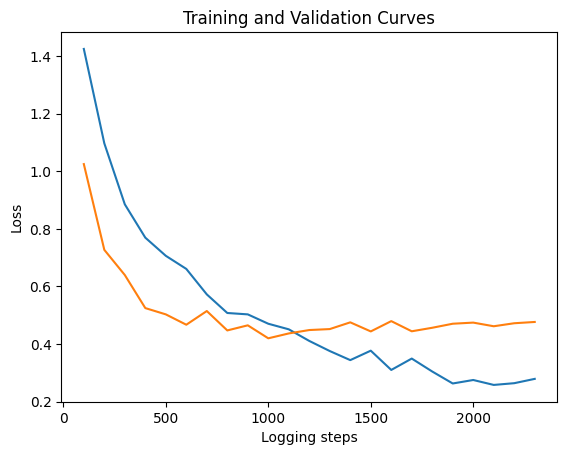

In [12]:
# Compute training and validation curve
train_loss_list = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss_list = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
step_list = [log['step'] for log in trainer.state.log_history if 'loss' in log]
plt.plot(step_list, train_loss_list, label='Training loss')
plt.plot(step_list, eval_loss_list, label='Validation loss')
plt.xlabel('Logging steps')
plt.ylabel('Loss')
plt.title('Training and Validation Curves')
plt.show()

In [13]:
# Compute test accuracy
test_predictions = trainer.predict(test_dataset)
test_predicted_labels = test_predictions.predictions.argmax(axis=1)
test_labels = [label_map[emotion] for emotion in test['emotion'].to_list()]
test_accuracy = accuracy_score(test_labels, test_predicted_labels)

print('Test Accuracy:', test_accuracy)

Test Accuracy: 0.8598798970546182


In [30]:
example_dataset = ClassificationDataset(
    test["text"].to_list()[:100],
    test["emotion"].to_list()[:100],
    label_map
)

def find_unsuccessful(pred, target):
    for i, (a, b) in enumerate(zip(pred, target)):
        if a != b:
            return i
        
def find_successful(pred, target):
    for i, (a, b) in enumerate(zip(pred, target)):
        if a == b:
            return i

example_predictions = trainer.predict(example_dataset)
example_predicted_labels = example_predictions.predictions.argmax(axis=1)
example_predicted_labels = [list(label_map.keys())[value] for value in example_predicted_labels]
example_labels = test["emotion"].to_list()[:100]

unsuccessful_index = find_unsuccessful(example_predicted_labels, example_labels)
successful_index = find_successful(example_predicted_labels, example_labels)

print("Successful example:")
print(test["text"].to_list()[successful_index])
print("Expected prediction:", example_labels[successful_index])
print("Actual prediction:", example_predicted_labels[successful_index])
print("")
print("Unsuccessful example:")
print(test["text"].to_list()[unsuccessful_index])
print("Expected prediction:", example_labels[unsuccessful_index])
print("Actual prediction:", example_predicted_labels[unsuccessful_index])

Successful example:
What a god
Expected prediction: neutral
Actual prediction: neutral

Unsuccessful example:
gaslighting!!!!! he’s manipulative
Expected prediction: neutral
Actual prediction: anger


In [15]:
print(classification_report(test_labels, test_predicted_labels, target_names=emotion, zero_division=0))

              precision    recall  f1-score   support

     sadness       0.74      0.70      0.72       452
     neutral       0.91      0.92      0.91      5263
       anger       0.59      0.58      0.59       553
        fear       0.71      0.77      0.73       213
         joy       0.81      0.73      0.77       513

    accuracy                           0.86      6994
   macro avg       0.75      0.74      0.74      6994
weighted avg       0.86      0.86      0.86      6994



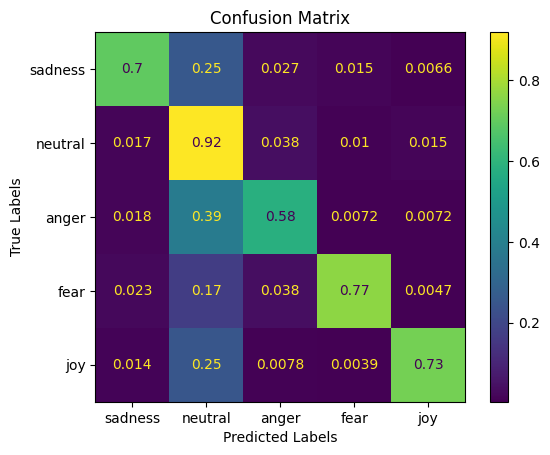

In [16]:
cm = ConfusionMatrixDisplay(confusion_matrix(test_labels, test_predicted_labels, normalize ='true'), display_labels=emotion)
cm.plot()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()